In [1]:
import pandas as pd
import numpy as np
import pickle

import src.model_builder as mb
import src.data_handling as dh
import src.modules as modules

In [2]:
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
genes = ["ESR1", "ERBB2", "CDK4"]

In [6]:
model = mb.CellLevelModel("Cancer", genes)

In [7]:
for gene in genes:
    filename = "/data/severs/saved_models/Cancer_diff_exp_" + gene
    model.models[gene] = pickle.load(open(filename, "rb"))

In [8]:
model.build_datasets()

Getting data for ESR1
Selected 1002 input genes with alpha = 4e-19
Getting data for ERBB2
Selected 999 input genes with alpha = 9e-14
Getting data for CDK4
Selected 998 input genes with alpha = 9e-09


In [9]:
model.shap_analysis("ESR1", interaction=False)

Calculating shap_values for ESR1... Completed
Shap analysis completed


## Finding missing genes in new dataset

In [10]:
shap_vals = model.shapley["ESR1"]["shap_vals"]

In [11]:
abs_shap = np.abs(shap_vals).mean(axis=0)
sorter = np.argsort(abs_shap)

In [ ]:
df = 

In [13]:
df_ = pd.read_pickle("/data/severs/correlation_p_values/Cancer_baseline_ESR1_correlation_expdiff_0.5.pkl")

In [14]:
shap_rank = list(df_.index[sorter])

In [17]:
missing_ranks = []
missing_genes = []
present_genes = []
for i, gene in enumerate(shap_rank):
    if gene not in df_baseline.columns:
        missing_ranks.append(i)
        missing_genes.append(gene)
    else:
        present_genes.append(gene)

## Use the old model on the new dataset

In [42]:
X, Y = model.get_data("ESR1")

In [44]:
X = X.drop(missing_genes, axis=1)

In [46]:
model.set_data(X, Y, "ESR1")

In [114]:
params = {'objective': 'reg:squarederror',
 'importance_type': 'gain',
 'learning_rate': 0.02,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 552,
 'n_jobs': 40,
 'subsample': 1,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

The model is first trained again on the old dataset with the subset of the selected genes that is present in the new dataset. This seems to have little effect on the results with a small drop of 0.03 in the RMSE. 

In [51]:
model.build_model(params, ["ESR1"])


CANCER - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  551 iters
      rmse: 1.1359663999999998
      Building regression model for ESR1, n_estimators=551 ... Complete
MODEL BUILDING COMPLETE




In [16]:
df_baseline = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_baseline.pkl")

In [148]:
X_val_new = df_baseline[present_genes]
Y_val = df_baseline["ESR1"]

In [149]:
X_val_new = X_val_new.reindex(X.columns, axis=1)
X_val = X_val_new[abs(Y_val_new)>0.5]
Y_val = Y_val_new[abs(Y_val_new)>0.5]

In [150]:
y_pred = model["ESR1"].predict(X_val)

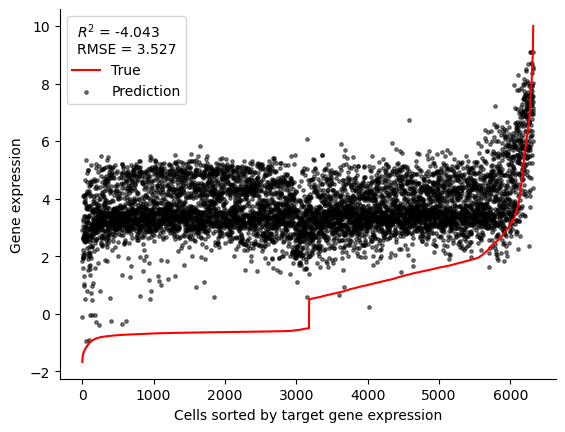

In [152]:
modules.plot_prediction(Y_val.values, y_pred)

In [196]:
model.datasets["ESR1"]["X_val"] = X_val

In [ ]:
model.shap_analysis("ESR1", interaction=False)

Calculating shap_values for ESR1... Completed
Calculating interactions for ESR1...

We see that the model cannot extrapolate to the new dataset.

### Train on baseline

In [155]:
model_2 = mb.CellLevelModel("Cancer_baseline", ["ESR1"])

In [156]:
model_2.build_datasets()

Getting data for ESR1
Counting NaNs:


  0%|          | 0/27938 [00:00<?, ?it/s]

Computing correlation and p-value:


  0%|          | 0/27938 [00:00<?, ?it/s]

Selected 1000 input genes with alpha = 7.000000000000001e-23


In [157]:
model_2.build_model(params)


CANCER_BASELINE - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  294 iters
      rmse: 1.0746286
      Building regression model for ESR1, n_estimators=294 ... Complete
MODEL BUILDING COMPLETE




In [158]:
y_pred = model_2.predict("ESR1", "X_val")

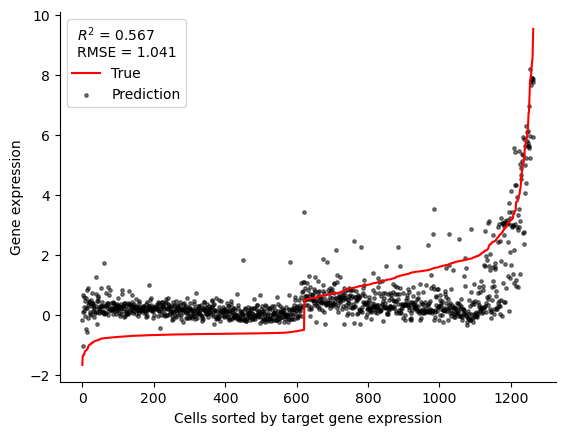

In [159]:
modules.plot_prediction(model_2.datasets["ESR1"]["y_val"].values, y_pred)

## Train on positively expressed baseline

In [160]:
model_3 = mb.CellLevelModel("Cancer_baseline", ["ESR1"])

In [161]:
model_3.build_datasets(diff_lim=0.3, positive_exp=True)

Getting data for ESR1
Counting NaNs:


  0%|          | 0/27938 [00:00<?, ?it/s]

Computing correlation and p-value:


  0%|          | 0/27938 [00:00<?, ?it/s]

Counting NaNs:


  0%|          | 0/27938 [00:00<?, ?it/s]

Computing correlation and p-value:


  0%|          | 0/27938 [00:00<?, ?it/s]

Selected 1000 input genes with alpha = 7.000000000000001e-23


In [162]:
model_3.build_model(params)


CANCER_BASELINE - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  293 iters
      rmse: 0.5725794
      Building regression model for ESR1, n_estimators=293 ... Complete
MODEL BUILDING COMPLETE




In [163]:
y_pred_3 = model_3.predict("ESR1", "X_val")

In [ ]:
model_3.datasets["ESR1"]["y_train"]

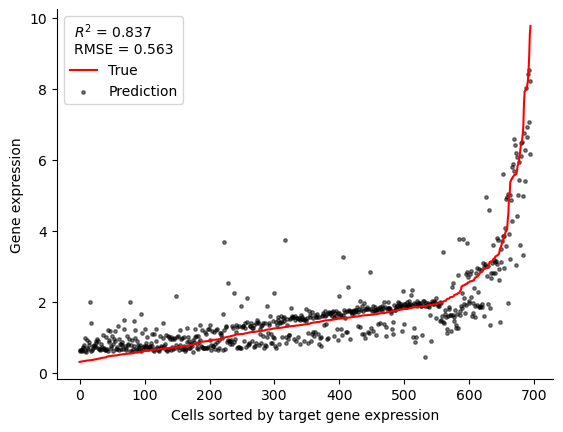

In [164]:
modules.plot_prediction(model_3.datasets["ESR1"]["y_val"].values, y_pred_3)

## Test of model on 2mnd test

In [177]:
selected_v = model_3.datasets["ESR1"]["X_val"].columns

In [178]:
df_2mnd = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_2mnd.pkl")

X_2mnd = df_2mnd[selected_v]
Y_2mnd = df_2mnd["ESR1"]
X_2mnd = X_2mnd.reindex(selected_v, axis=1)
X_2mnd = X_2mnd[Y_2mnd>0.3]
Y_2mnd = Y_2mnd[Y_2mnd>0.3]

In [179]:
y_pred_2mnd = model_3["ESR1"].predict(X_2mnd)

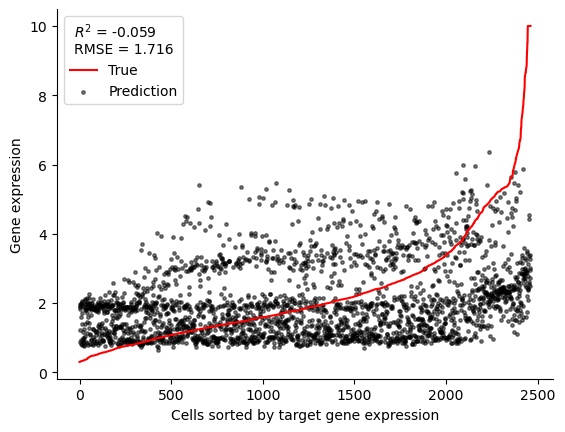

In [180]:
modules.plot_prediction(Y_2mnd.values, y_pred_2mnd)

Performance on 2mnd is very bad. And there seems to be significant differences between the datasets

## Test of model on 4mnd test
There are much fewer samples meeting the criteria in 4mnd dataset. 

In [168]:
selected_v = model_3.datasets["ESR1"]["X_val"].columns

In [169]:
df_4mnd = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_4mnd.pkl")

X_4mnd = df_4mnd[selected_v]
Y_4mnd = df_4mnd["ESR1"]

X_4mnd = X_4mnd.reindex(selected_v, axis=1)
X_4mnd = X_4mnd[Y_4mnd>0.3]
Y_4mnd = Y_4mnd[Y_4mnd>0.3]

In [172]:
y_pred_4mnd = model_3["ESR1"].predict(X_4mnd)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


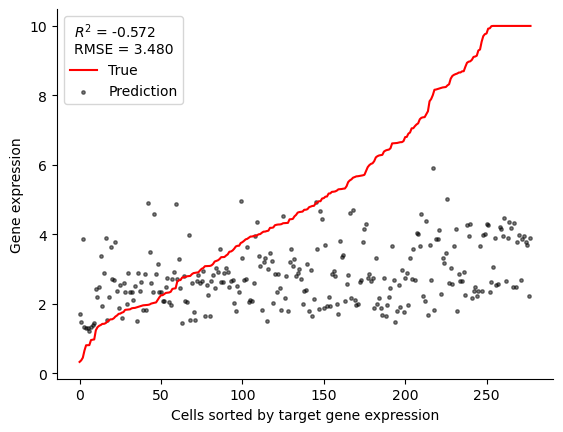

In [173]:
modules.plot_prediction(Y_4mnd.values, y_pred_4mnd)

## Difference in data sets
The expression of ESR1 decreases with treatment. We should also find a similarity measure between the entire range of input values to see if they change. 

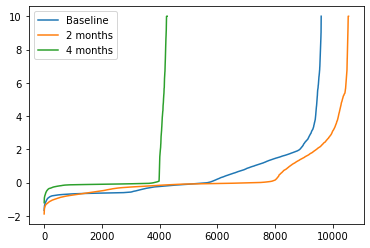

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
sorter = np.argsort(df_baseline["ESR1"].values)
ax.plot(df_baseline["ESR1"].values[sorter], label="Baseline")
sorter = np.argsort(df_2mnd["ESR1"].values)
ax.plot(df_2mnd["ESR1"].values[sorter], label="2 months")
sorter = np.argsort(df_4mnd["ESR1"].values)
ax.plot(df_4mnd["ESR1"].values[sorter], label="4 months")
plt.legend()